In [282]:
%matplotlib inline
%config InlineBackend.figure_format= 'retina'

import numpy as np
from PIL import Image
from pylab import *
import matplotlib.pyplot as plt
import torchvision
import sys
import torch
import helper  
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
from torch import nn
import torch.nn.functional as f
from torch.utils.data import Dataset, TensorDataset, DataLoader, ConcatDataset
from cdataset import musicianDataset
from torch.autograd import Variable 

In [283]:
trainpath="Image1/train/"
valpath="Image1/val/"
testpath="Image1/test/"

In [284]:
device= torch.device('cuda' if torch.cuda.is_available()else 'cpu')
normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],)
 
batch_size=64
img_size =(224,224) 

transforms = transforms.Compose([ transforms.Resize(img_size,Image.NEAREST),transforms.ToTensor(),normalize,])
train_data = torchvision.datasets.ImageFolder(root=trainpath, transform=transforms)
val_data = torchvision.datasets.ImageFolder(root=valpath,transform=transforms)
test_data = torchvision.datasets.ImageFolder(root=testpath,transform=transforms)
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
classes =('as', 'bl','ma','ted')

In [285]:
dataiter = iter(train_data_loader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 3, 224, 224])
torch.Size([64])


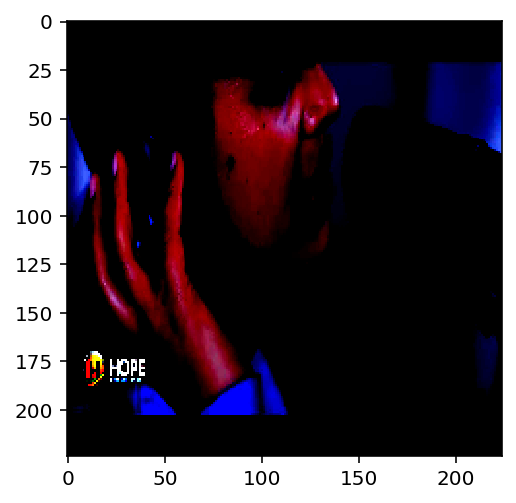

In [286]:
plt.imshow(torchvision.utils.make_grid(images[3], nrow=5).permute(1, 2, 0))

In [287]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(150528, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,4)
    def forward(self, x):
        x = x.view(-1, 150528)
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = self.fc3(x)
        return x
network = Network()

In [288]:
criterion = nn.CrossEntropyLoss()
outputs=network(images) 
loss = criterion(outputs, labels)
print(loss)

tensor(1.3858, grad_fn=<NllLossBackward>)


In [289]:
trainloss,testloss= [],[]

def validation(network , val_data_loader, criterion):
    valLoss=0
    accuracy=0
    for images, labels in iter (val_data_loader):
        images = images.view(images.shape[0],-1)
        output= network(images)
        valLoss +=criterion(output, labels).item()
        probabilities=torch.exp(output)
        equality=(labels.data == probabilities.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    return valLoss, accuracy 


In [290]:
from torch import optim
optimizer=optim.SGD(network.parameters(), lr=0.001)

In [297]:
epochs=20
for e in range(epochs):
    running_loss=0
    for i, data in enumerate(train_data_loader, 0):
         # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
         # print statistics
        running_loss += loss.item()
        
        trainloss.append(running_loss / len(train_data_loader))
       

        with torch.no_grad():
            validation_loss,accuracy =validation(network, val_data_loader, criterion)
            testloss.append(validation_loss/len(val_data_loader))
        network.train()     
    else:
        print(f"traing loss: {running_loss / len(train_data_loader)}", f"valloss: {validation_loss/len(val_data_loader)}",f"Accuracy: {accuracy/len(val_data_loader)}")
        
        
        
        

traing loss: 0.4897017478942871 valloss: 0.541268527507782 Accuracy: 0.9375
traing loss: 0.47133023540178937 valloss: 0.5188277959823608 Accuracy: 1.0
traing loss: 0.45436573028564453 valloss: 0.5088392496109009 Accuracy: 1.0
traing loss: 0.43272021412849426 valloss: 0.4798418879508972 Accuracy: 1.0
traing loss: 0.4193517565727234 valloss: 0.4579475224018097 Accuracy: 1.0
traing loss: 0.40183477600415546 valloss: 0.46087318658828735 Accuracy: 1.0
traing loss: 0.3911628524462382 valloss: 0.4497426748275757 Accuracy: 1.0
traing loss: 0.36952805519104004 valloss: 0.424085795879364 Accuracy: 1.0
traing loss: 0.3575814565022786 valloss: 0.4279484450817108 Accuracy: 1.0
traing loss: 0.3484920660654704 valloss: 0.4093354046344757 Accuracy: 1.0
traing loss: 0.3391944070657094 valloss: 0.38541606068611145 Accuracy: 1.0
traing loss: 0.32007930676142377 valloss: 0.3846372067928314 Accuracy: 1.0
traing loss: 0.314564973115921 valloss: 0.36259138584136963 Accuracy: 1.0
traing loss: 0.30305399497350

GroundTruth:    as   ma  ted   ma   as   as   ma   ma   bl  ted


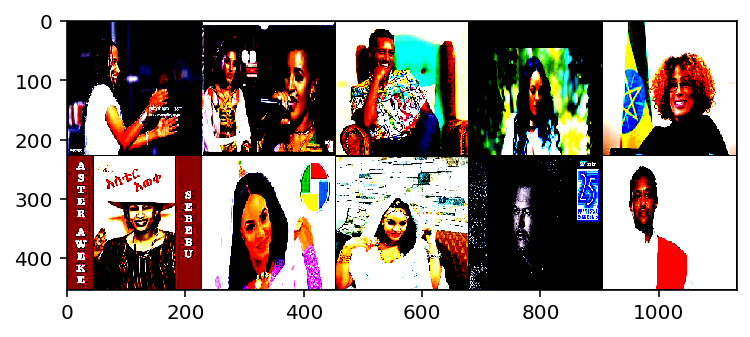

In [298]:
network.eval()
dataiter = iter(test_data_loader )
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images, nrow=5).permute(1, 2, 0))
print('GroundTruth:',''.join('%5s' % classes[labels[j]] for j in range(10)))


In [299]:
outputs = network(images)

In [300]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(10)))

Predicted:     as   ted    as    as    as    as    ma   ted    bl   ted


In [301]:
network.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        outputs = network(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10 test images: 60 %


In [302]:
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        outputs = network(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(4):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of    as : 100 %
Accuracy of    bl : 100 %
Accuracy of    ma : 25 %
Accuracy of   ted : 50 %


In [251]:
from PIL import Image
path="C:/Users/test/Music/image1/val/as/images (14).jpg"
labels = ['as','bl','ma','ted']
img = Image.open(path)
img = transforms(img)
img = img.unsqueeze(0)
prediction = network(img)
prediction = prediction.argmax()
print(labels[prediction])

ma
